In [168]:
import pandas as pd
import pandas_datareader.data as web
import seaborn
from statsmodels.tsa.stattools import coint, adfuller
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests
from statsmodels.tsa.vector_ar.var_model import VAR
import numpy as np
import statsmodels.api as sm 
from statsmodels.formula.api import ols
import datetime as dt
import datetime
import sqlite3
import os
import time
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from financetoolkit import Toolkit
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
from scipy.stats import norm
import plotly.express as px
import pandas_datareader as pdr
import seaborn as sns
from datetime import datetime
import calendar
import pandas_datareader.data as web
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings("ignore")
register_matplotlib_converters()
sns.set_theme()
%matplotlib inline

# Probability of a Touch Framework

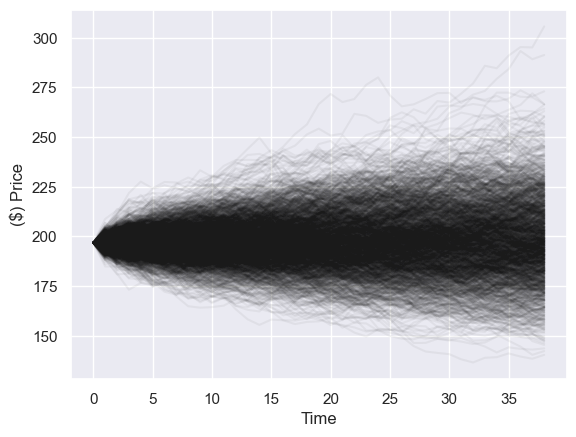

In [169]:
days = 38      # I'm going to use calendar days
strike = 215.0
dt = 1.0       # 1 day time step
sample = 2000  # Number of simulations
r = 0.02/252    # risk-free rate
sigma = 0.269 / np.sqrt(252)                        # I could use Implied volatility here
epsilon = np.random.normal(size = (sample, days))   # this is your random shock
ds_s = r * dt + sigma * np.sqrt(dt) * epsilon       # this is simulating the returns 
prices = np.zeros((epsilon.shape[0], epsilon.shape[1]+1))
prices[:,0] = 196.8
for i in range(days):
    prices[:,i+1] = prices[:,i] + ds_s[:,i] * prices[:,i] 
for i in range(prices.shape[0]):
    plt.plot(np.linspace(0,days,days+1), prices[i,:], 'k', alpha=0.05)
plt.xlabel("Time")
plt.ylabel("($) Price")
plt.grid(True)
plt.show()

ind = np.where(prices >= strike)
U = np.unique(ind[0])            # get the unique paths where this does indeed touch the strike
pot = len(U)/sample


# SPX Options Data

In [174]:
def get_spx_options():    
    options_data = []
    path = '/Users/ryanfinegan/Documents/PropTrading/spx_data/'
    dir_list = os.listdir(path)
    for file in dir_list:
        monthly_data = pd.read_csv(f"/Users/ryanfinegan/Documents/PropTrading/spx_data/{file}", sep=',')
        options_data.append(monthly_data)
    spx = pd.concat(options_data)
    col_list = []
    for i in spx.columns:
        col_list.append(i.replace('[', '').replace(']', '').replace(' ',''))
    spx.columns = col_list
    spx = spx.set_index('QUOTE_DATE').sort_index()
    spx['EXPIRE_DATE'] = pd.to_datetime(spx['EXPIRE_DATE'])
    spx.index = pd.to_datetime(spx.index)
    spx['maturity'] = (spx['EXPIRE_DATE'] - spx.index).dt.days
    spx['maturity'] = spx['maturity'].astype(int)
    return spx

df = get_spx_options()

# For One Maturity on a Specific Close 

In [204]:
pd.set_option('display.max_columns', None)
call = df[(df['QUOTE_READTIME'] == ' 2023-12-29 16:00') & (df['maturity'] == 90)]
call = call[(call['C_LAST']>0.0) & (call['P_LAST']>0.0)]
call['C_IV'] = call['C_IV'].replace(' ',np.nan).astype(float)
call['P_IV'] = call['P_IV'].replace(' ',np.nan).astype(float)
call['C_VOLUME'] = call['C_VOLUME'].replace(' ',np.nan).astype(float) 
call['P_VOLUME'] = call['P_VOLUME'].replace(' ',np.nan).astype(float) 

call['CallPrice'] = (call['C_BID'] + call['C_ASK']) / 2
call['PutPrice'] = (call['P_BID'] + call['P_ASK']) / 2
call['impliedMoveCall'] = (call['UNDERLYING_LAST']) * (call['C_IV']) * (np.sqrt(call['DTE']/365))
call['impliedMovePut'] = (call['UNDERLYING_LAST']) * (call['P_IV']) * (np.sqrt(call['DTE']/365))
print(call.sort_values("C_VOLUME", ascending=False).dropna()['impliedMovePut'].mean())
print(call.sort_values("C_VOLUME", ascending=False).dropna()['impliedMoveCall'].mean())

486.8774921707625
488.4293546234325


# Picking The Option Chain

In [205]:
opt = call.sort_values("C_VOLUME", ascending=False).dropna()
spx_option = opt[opt['UNDERLYING_LAST']<=opt['STRIKE']].head(1).tail(1)
display(spx_option)

,QUOTE_UNIXTIME,QUOTE_READTIME,QUOTE_TIME_HOURS,UNDERLYING_LAST,EXPIRE_DATE,EXPIRE_UNIX,DTE,C_DELTA,C_GAMMA,C_VEGA,C_THETA,C_RHO,C_IV,C_VOLUME,C_LAST,C_SIZE,C_BID,C_ASK,STRIKE,P_BID,P_ASK,P_SIZE,P_LAST,P_DELTA,P_GAMMA,P_VEGA,P_THETA,P_RHO,P_IV,P_VOLUME,STRIKE_DISTANCE,STRIKE_DISTANCE_PCT,maturity,CallPrice,PutPrice,impliedMoveCall,impliedMovePut
QUOTE_DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-12-29,1703883600,2023-12-29 16:00,16.0,4772.17,2024-03-28,1711656000,89.96,0.54221,0.00133,9.40066,-0.92649,6.11905,0.12352,251.0,124.31,100 x 15,125.5,130.9,4800.0,102.5,103.3,1 x 30,110.6,-0.48442,0.00161,9.16468,-0.39009,-4.20533,0.11676,18.0,27.8,0.006,90,128.2,102.9,292.638512,276.622998


# Simulating the Price with and without Hurst

,FGBM: 0.6,GBM: 0.5
0.10,4549.852375,4268.324718
0.25,4769.628786,4597.402936
0.50,5056.452288,5038.811750
0.75,5317.052105,5450.102099
0.90,5572.206916,5867.986142


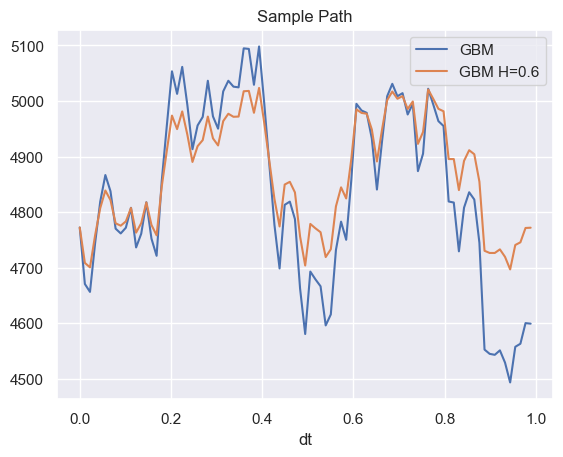

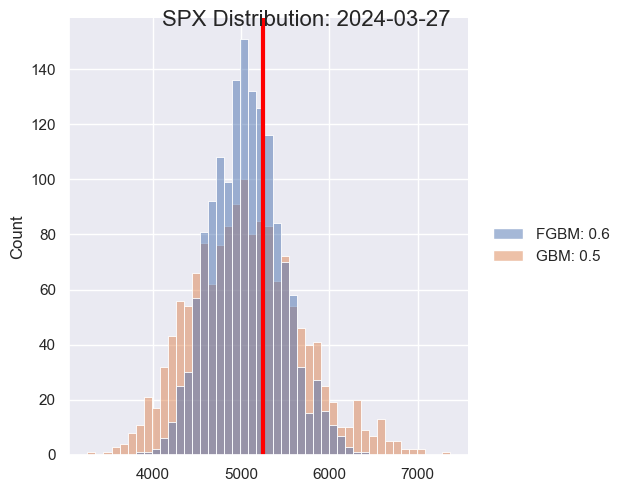

In [206]:
import datetime

S0 = spx_option['UNDERLYING_LAST'][0]  # 4772.17
dte = int(spx_option['DTE'][0])        # 89
dt = 1/dte                             # 0.011235955056179775
mu = 0.06                              # expected return
vol = spx_option['C_IV'][0]            # 0.12352  (implied volatility given by options data)
H = 0.6                                # hurst 

def gbm(S0, dte, dt, mu, vol, H, sims):
    fgbm = []
    geo_bm = []
    for n in range(sims):
        df = pd.DataFrame(np.arange(0, 1, dt), columns=['dt'])
        df['mu'] = mu                                           # in percent
        df['sigma'] = vol                                       # in percent 
        df['z'] = np.random.normal(0,1, len(df))
        df['dBh'] = df['z'] * np.sqrt(dt **(2*0.5))
        df[f'dBh H={H}'] = df['z'] * np.sqrt(dt **(2*H))
        df.loc[0, 'GBM'] = S0
        df.loc[0, f'GBM H={H}'] = S0
        for i in range(0, len(df)-1):
            df.loc[i+1, 'GBM'] = df.loc[i, 'GBM'] + (df.loc[i+1, 'mu']*df.loc[i, 'GBM']*dt) + (df.loc[i+1, 'sigma']*df.loc[i, 'GBM']*df.loc[i+1, 'dBh'])
            df.loc[i+1, f'GBM H={H}'] = df.loc[i, f'GBM H={H}'] + (df.loc[i+1, 'mu']*df.loc[i, f'GBM H={H}']*dt) + (df.loc[i+1, 'sigma']*df.loc[i, f'GBM H={H}']*df.loc[i+1, f'dBh H={H}'])
        fgbm.append(df[f'GBM H={H}'].iloc[-1])
        geo_bm.append(df['GBM'].iloc[-1])
    df[['dt','GBM',f'GBM H={H}']].set_index('dt').plot(title="Sample Path")
    return df, fgbm, geo_bm

simy = gbm(S0, dte, dt, mu, vol, H, 1500)
diff = pd.DataFrame({f"FGBM: {H}":simy[1], "GBM: 0.5":simy[2]})
ax = sns.displot(diff)
future = (spx_option.index + datetime.timedelta(days = dte))
date_fut = str(future[0]).split()[0]
ax.fig.suptitle(f'SPX Distribution: {date_fut}',
                  fontsize=16, fontdict={"weight": "bold"})
plt.axvline(5248.490234, color="red", label="SPX", linewidth=3)

display(pd.DataFrame([diff.quantile(0.1),diff.quantile(0.25),diff.quantile(0.5),diff.quantile(0.75),diff.quantile(0.9)]))

# 5248.490234

# Another Try

In [207]:
pd.set_option('display.max_columns', None)
call = df[(df['QUOTE_READTIME'] == ' 2023-04-03 16:00') & (df['maturity'] == 88)]
call = call[(call['C_LAST']>0.0) & (call['P_LAST']>0.0)]
call['C_IV'] = call['C_IV'].replace(' ',np.nan).astype(float)
call['P_IV'] = call['P_IV'].replace(' ',np.nan).astype(float)
call['C_VOLUME'] = call['C_VOLUME'].replace(' ',np.nan).astype(float) 
call['P_VOLUME'] = call['P_VOLUME'].replace(' ',np.nan).astype(float) 

call['CallPrice'] = (call['C_BID'] + call['C_ASK']) / 2
call['PutPrice'] = (call['P_BID'] + call['P_ASK']) / 2
call['impliedMoveCall'] = (call['UNDERLYING_LAST']) * (call['C_IV']) * (np.sqrt(call['DTE']/365))
call['impliedMovePut'] = (call['UNDERLYING_LAST']) * (call['P_IV']) * (np.sqrt(call['DTE']/365))
print(call.sort_values("C_VOLUME", ascending=False).dropna()['impliedMovePut'].mean())
print(call.sort_values("C_VOLUME", ascending=False).dropna()['impliedMoveCall'].mean())

436.13557116617886
434.82859652250414


# Picking Option Chain

In [208]:
opt = call.sort_values("C_VOLUME", ascending=False).dropna()
spx_option = opt[opt['UNDERLYING_LAST']<=opt['STRIKE']].head(1).tail(1)
display(spx_option)

,QUOTE_UNIXTIME,QUOTE_READTIME,QUOTE_TIME_HOURS,UNDERLYING_LAST,EXPIRE_DATE,EXPIRE_UNIX,DTE,C_DELTA,C_GAMMA,C_VEGA,C_THETA,C_RHO,C_IV,C_VOLUME,C_LAST,C_SIZE,C_BID,C_ASK,STRIKE,P_BID,P_ASK,P_SIZE,P_LAST,P_DELTA,P_GAMMA,P_VEGA,P_THETA,P_RHO,P_IV,P_VOLUME,STRIKE_DISTANCE,STRIKE_DISTANCE_PCT,maturity,CallPrice,PutPrice,impliedMoveCall,impliedMovePut
QUOTE_DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-04-03,1680552000,2023-04-03 16:00,16.0,4123.95,2023-06-30,1688155200,88.0,0.52885,0.00119,8.06093,-0.98071,4.95844,0.16932,1760.0,141.37,7 x 7,142.7,143.5,4150.0,131.3,132.1,30 x 7,136.45,-0.48223,0.00128,8.00274,-0.57739,-4.17143,0.16797,1750.0,26.1,0.006,88,143.1,131.7,342.85979,340.126145


,FGBM: 0.6,GBM: 0.5
0.10,3762.488410,3436.647207
0.25,4028.360790,3826.466029
0.50,4361.504798,4331.520840
0.75,4661.637244,4805.974112
0.90,4951.497880,5284.639317


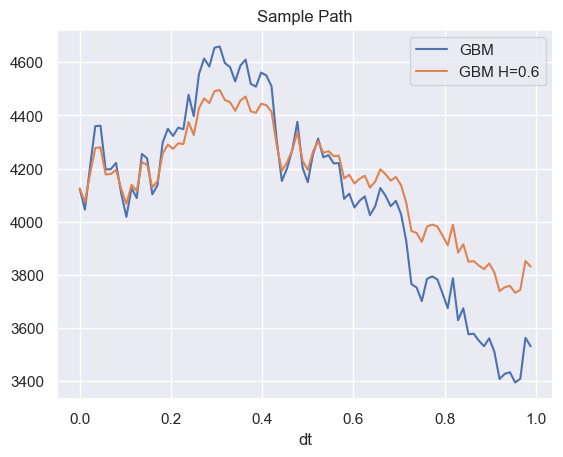

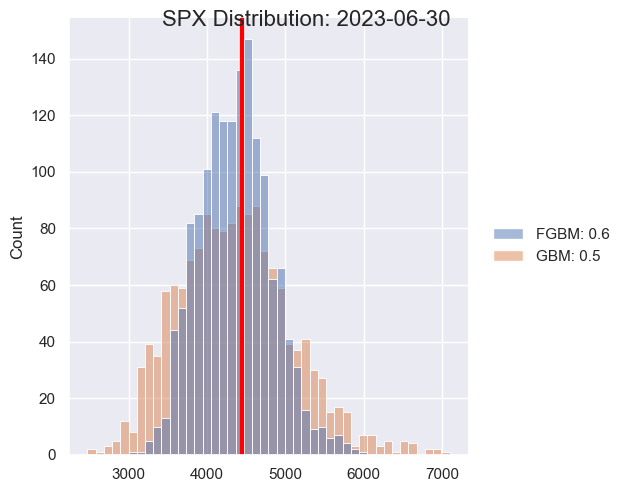

In [209]:
import datetime

S0 = spx_option['UNDERLYING_LAST'][0]  # 4772.17
dte = int(spx_option['DTE'][0])        # 89
dt = 1/dte                             # 0.011235955056179775
mu = 0.06                              # expected return
vol = spx_option['C_IV'][0]            # 0.12352  (implied volatility given by options data)
H = 0.6                                # hurst 

simy = gbm(S0, dte, dt, mu, vol, H, 1500)
diff = pd.DataFrame({f"FGBM: {H}":simy[1], "GBM: 0.5":simy[2]})
ax = sns.displot(diff)
future = (spx_option.index + datetime.timedelta(days = dte))
date_fut = str(future[0]).split()[0]
ax.fig.suptitle(f'SPX Distribution: {date_fut}',
                  fontsize=16, fontdict={"weight": "bold"})
plt.axvline(4450.379883, color="red", label="SPX", linewidth=3)

display(pd.DataFrame([diff.quantile(0.1),diff.quantile(0.25),diff.quantile(0.5),diff.quantile(0.75),diff.quantile(0.9)]))

# 4450.379883

# Try for Another Expiry

In [210]:
pd.set_option('display.max_columns', None)
call = df[(df['QUOTE_READTIME'] == ' 2022-01-03 16:00') & (df['maturity'] == 116)]
call = call[(call['C_LAST']>0.0) & (call['P_LAST']>0.0)]
call['C_IV'] = call['C_IV'].replace(' ',np.nan).astype(float)
call['P_IV'] = call['P_IV'].replace(' ',np.nan).astype(float)
call['C_VOLUME'] = call['C_VOLUME'].replace(' ',np.nan).astype(float) 
call['P_VOLUME'] = call['P_VOLUME'].replace(' ',np.nan).astype(float) 

call['CallPrice'] = (call['C_BID'] + call['C_ASK']) / 2
call['PutPrice'] = (call['P_BID'] + call['P_ASK']) / 2
call['impliedMoveCall'] = (call['UNDERLYING_LAST']) * (call['C_IV']) * (np.sqrt(call['DTE']/365))
call['impliedMovePut'] = (call['UNDERLYING_LAST']) * (call['P_IV']) * (np.sqrt(call['DTE']/365))
print(call.sort_values("C_VOLUME", ascending=False).dropna()['impliedMovePut'].mean())
print(call.sort_values("C_VOLUME", ascending=False).dropna()['impliedMoveCall'].mean())

519.6132346491798
511.7439452926083


In [211]:
opt = call.sort_values("C_VOLUME", ascending=False).dropna()
spx_option = opt[opt['UNDERLYING_LAST']<=opt['STRIKE']].head(1).tail(1)
display(spx_option)

,QUOTE_UNIXTIME,QUOTE_READTIME,QUOTE_TIME_HOURS,UNDERLYING_LAST,EXPIRE_DATE,EXPIRE_UNIX,DTE,C_DELTA,C_GAMMA,C_VEGA,C_THETA,C_RHO,C_IV,C_VOLUME,C_LAST,C_SIZE,C_BID,C_ASK,STRIKE,P_BID,P_ASK,P_SIZE,P_LAST,P_DELTA,P_GAMMA,P_VEGA,P_THETA,P_RHO,P_IV,P_VOLUME,STRIKE_DISTANCE,STRIKE_DISTANCE_PCT,maturity,CallPrice,PutPrice,impliedMoveCall,impliedMovePut
QUOTE_DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-01-03,1641243600,2022-01-03 16:00,16.0,4795.57,2022-04-29,1651262400,115.96,0.13653,0.00071,5.94805,-0.29867,2.01116,0.12266,33.0,27.8,62 x 87,21.9,22.6,5175.0,409.4,416.1,100 x 69,508.98,-0.85609,0.00071,6.08351,-0.39414,-14.42624,0.12495,200.0,379.4,0.079,116,22.25,412.75,331.5514,337.741297


,FGBM: 0.6,GBM: 0.5
0.10,4621.442898,4343.454612
0.25,4839.754893,4680.761378
0.50,5064.540484,5037.315272
0.75,5339.414751,5481.486907
0.90,5595.523166,5911.531571


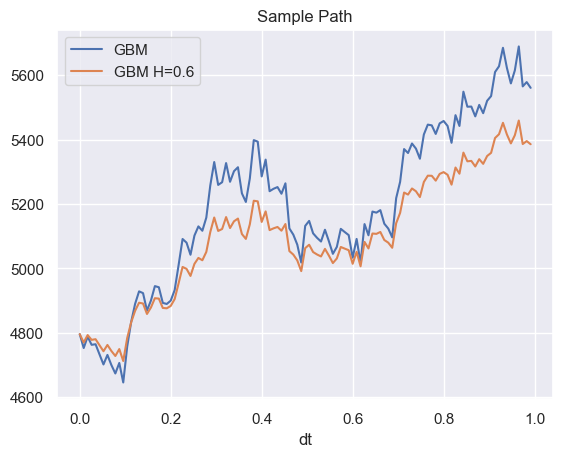

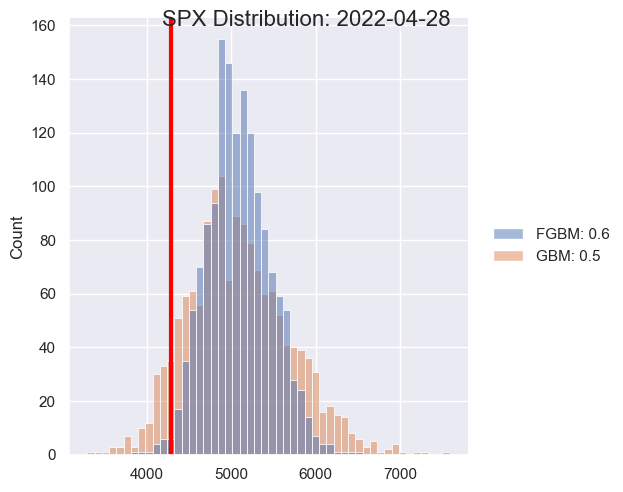

In [212]:
import datetime

S0 = spx_option['UNDERLYING_LAST'][0]  # 4772.17
dte = int(spx_option['DTE'][0])        # 89
dt = 1/dte                             # 0.011235955056179775
mu = 0.06                              # expected return
vol = spx_option['C_IV'][0]            # 0.12352  (implied volatility given by options data)
H = 0.6                                # hurst 

simy = gbm(S0, dte, dt, mu, vol, H, 1500)
diff = pd.DataFrame({f"FGBM: {H}":simy[1], "GBM: 0.5":simy[2]})
ax = sns.displot(diff)
future = (spx_option.index + datetime.timedelta(days = dte))
date_fut = str(future[0]).split()[0]
ax.fig.suptitle(f'SPX Distribution: {date_fut}',
                  fontsize=16, fontdict={"weight": "bold"})
plt.axvline(4287.5, color="red", label="SPX", linewidth=3)


display(pd.DataFrame([diff.quantile(0.1),diff.quantile(0.25),diff.quantile(0.5),diff.quantile(0.75),diff.quantile(0.9)]))

# 4287.5	

# See How Close to Real Data

In [ ]:
import pandas as pd
import pandas_datareader.data as web
import seaborn
from statsmodels.tsa.stattools import coint, adfuller
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests
from statsmodels.tsa.vector_ar.var_model import VAR
import numpy as np
import statsmodels.api as sm 
from statsmodels.formula.api import ols
import datetime as dt
import datetime
import sqlite3
import os
import time
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from financetoolkit import Toolkit
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
from scipy.stats import norm
import plotly.express as px
import pandas_datareader as pdr
import seaborn as sns
from datetime import datetime
import calendar
import pandas_datareader.data as web
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings("ignore")
register_matplotlib_converters()
sns.set_theme()
%matplotlib inline

class Macro:
    
    """
    This class is mainly for my paper trading in spot markets. Derivatives will have a separate script. 
    """
    
    def __init__(self, condition, start, end):
        if condition == 1:
            self.period1 = start
            self.period2 = end
        else:
            self.period1 = int(time.mktime((dt.datetime.now() - dt.timedelta(365*35)).timetuple()))
            self.period2 = int(time.mktime(dt.datetime.now().timetuple()))
        
        self.fred_start = str(dt.datetime.now() - dt.timedelta(365*50)).split()[0]
        self.fred_end = dt.datetime.now()
        self.interval = '1d'
        self.symbols_list = "USREC","GDPC1","CPIAUCSL","VIXCLS","DSERRA3M086SBEA","FRBKCLMCILA","PCEC96","DGDSRX1","PCEDGC96","CMRMTSPL","INDPRO","W875RX1","PAYEMS","M2REAL",'WSHOTSL','WSHOMCB','WSHOFADSL','WLCFLL','WORAL','WEI','WLRRAL','WDTGAL'

    def macro(self):
        symbols = []
        for ticker in self.symbols_list: 
            try:
                r = web.DataReader(ticker,'fred', self.fred_start, self.fred_end)
                r['ticker'] = ticker
                symbols.append(r)
            except:
                msg = 'Failed to read symbol: {0!r}, replacing with NaN.'
        try:
            connection = sqlite3.connect('tradable_universe')
            for i in symbols:
                i.columns = 'close','ticker'
            final = pd.concat(symbols)
            final_df = final.reset_index()
            final_df.to_sql("macro_signals",connection, if_exists='replace', index=False)
            connection.commit()
            connection.close()
        except:
            print("There was an error in uploading the macro table into the sql database")
        return symbols, final_df
    
    
    def ticker_filter(self, ticker, final):
        return final[final['ticker']==f"{ticker}"]
    
    def dataframe(self, tickers, final, start, end):
        
        """
        Inputs: The tickers you want to filter by and a raw unfiltered data query from trading database. 
        Outputs: A dataframe with the columns being the names of the selected tickers and the values being 
        the adjusted adjusted close prices. 
        """
        
        new_df = []
        for ticker in tickers:
            new = final[final['ticker']==f"{ticker}"]
            new_df.append(new)
        main = pd.concat(new_df)
        df = main.pivot_table(index = main.index, columns = "ticker", values = 'close')
        return df[start:end]
    
class Trading:
    
    def __init__(self, condition, start, end):
        if condition == 1:
            self.period1 = start
            self.period2 = end
        else:
            self.period1 = int(time.mktime((dt.datetime.now() - dt.timedelta(365*35)).timetuple()))
            self.period2 = int(time.mktime(dt.datetime.now().timetuple()))
        
        self.fred_start = str(dt.datetime.now() - dt.timedelta(365*35)).split()[0]
        self.fred_end = dt.datetime.now()
        self.interval = '1d'
        self.ticker_list = ["^GSPC",'^VIX'] 
    
    def yahoo_universe(self):
        web3 = []
        failed = []
        for security in self.ticker_list:
            try:                                                    
                interval = '1d' 
                query_string = f'https://query1.finance.yahoo.com/v7/finance/download/{security}?period1={self.period1}&period2={self.period2}&interval={self.interval}&events=history&includeAdjustedClose=true'
                df = pd.read_csv(query_string).set_index("Date")
                df['ticker'] = security
                df.columns = ['Open', 'High', 'Low','Close','Adj Close','Volume','ticker']
                web3.append(df)
            except:
                failed.append(security)                                                
                pass
            final = pd.concat(web3)
            df_final = final.reset_index()
        return df_final, web3, failed

    
    def trading_sql(self, data_file):
        try:
            conn = sqlite3.connect('tradable_universe') 
            data_file.to_sql("consensusinvestable", conn, if_exists='replace', index = False)
            conn.commit()
            conn.close()
            print("Updating the sql table was a success")
        except:
            print("Was unsuccessful in uploading the dataframe into the datatable. ")
    
    
    def to_trading_sql(self, data):
        
        """
        Inputs: dataframe you want to upload
        Outputs: saves SQL table to the investable database 
        """
        
        try:
            connection = sqlite3.connect(config.db_file)
            data.to_sql("consensusinvestable", connection, if_exists='replace', index=False)
            connection.commit()
            connection.close()
            print("Uploading dataframe to database worked successfully.")
        except:
            print("Was unable to save the dataframe into the investable datatable.")

    
    def load_sql(self):
        try:
            conn = sqlite3.connect('tradable_universe') 
            df = pd.read_sql_query("SELECT * from consensusinvestable", conn)
            conn.commit()
            conn.close()
        except:
            print("Could not retrieve the datatable. ")
        return df
    
    
    def ticker_filter(self, ticker, final):
        return final[final['ticker']==f"{ticker}"]
    
    
    def dataframe(self, tickers, final, start, end):
        
        """
        Inputs: The tickers you want to filter by and a raw unfiltered data query from trading database. 
        Outputs: A dataframe with the columns being the names of the selected tickers and the values being 
        the adjusted adjusted close prices. 
        """
        
        new_df = []
        for ticker in tickers:
            new = final[final['ticker']==f"{ticker}"]
            new_df.append(new)
        main = pd.concat(new_df)
        df = main.pivot_table(index = main.index, columns = "ticker", values = 'Adj Close')
        return df[start:end]

In [ ]:
main = Trading(0, "2018-01-01", "2020-01-01")   # set first input to one if you want exact date inputs
df, df1, df2 = main.yahoo_universe()            # dont have to run this everytime
main.trading_sql(df) 

Updating the sql table was a success


In [ ]:
final = main.load_sql().set_index("Date") # "SPY",'RSP',"XLV", 'XLY','^DJT', 'XLK','^RUT','XES','XSW','XSD' ,'QQQ'
tickers1 =['^GSPC','^VIX']
start = '1990-01-01'
end = dt.datetime.now()
final.index = pd.to_datetime(final.index)
dfcap = main.dataframe(tickers1, final, start, end)
dfcap = dfcap.dropna()
daily = dfcap.copy()
daily = daily['2003-01-02':]

In [199]:
daily[date_fut:].head(1)

ticker,^GSPC,^VIX
Date,,
2023-06-30,4450.379883,13.59


In [ ]:
daily['SP500 Return'] = daily['^GSPC'].pct_change(21)
daily['SP500 Abs Return'] = abs(daily['SP500 Return'])
daily['SP500 30d Fwd'] = daily['SP500 Return'].shift(-21)
daily['VIXpctl'] = daily['^VIX']/100
daily

ticker,^GSPC,^VIX,SP500 Return,SP500 Abs Return,SP500 30d Fwd,VIXpctl
Date,,,,,,
2003-01-02,909.030029,25.389999,NaN,NaN,-0.053585,0.2539
2003-01-03,908.590027,24.680000,NaN,NaN,-0.066466,0.2468
2003-01-06,929.010010,24.910000,NaN,NaN,-0.091947,0.2491
2003-01-07,922.929993,25.129999,NaN,NaN,-0.091860,0.2513
2003-01-08,909.929993,25.530001,NaN,NaN,-0.088183,0.2553
...,...,...,...,...,...,...
2024-07-09,5576.979980,12.510000,0.041850,0.041850,NaN,0.1251
2024-07-10,5633.910156,12.850000,0.053660,0.053660,NaN,0.1285
2024-07-11,5584.540039,12.920000,0.041738,0.041738,NaN,0.1292


# Options Data

# Picking One Day and One Expiry to Get Distribution